In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [3]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

In [4]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [5]:
df['Date']=df.index

In [7]:
start_date='2016-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [8]:
df=df.loc[mask]

In [9]:
df=df.loc[mask]

In [10]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [11]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [12]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [13]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [15]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1187, 50) Y.shape (1187,)


In [16]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [18]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 400)          323200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 400)          961600    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 100)               40100     
                                                           

In [19]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [20]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [22]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
26/26 [==============================] - 27s 772ms/step - loss: 543.6636 - mae: 17.6235 - mse: 543.6636 - val_loss: 2514.4233 - val_mae: 34.4721 - val_mse: 2514.4233
Epoch 2/100
26/26 [==============================] - 18s 704ms/step - loss: 541.7939 - mae: 17.5881 - mse: 541.7939 - val_loss: 2513.3340 - val_mae: 34.4449 - val_mse: 2513.3340
Epoch 3/100
26/26 [==============================] - 19s 716ms/step - loss: 540.1603 - mae: 17.5850 - mse: 540.1603 - val_loss: 2511.5188 - val_mae: 34.4237 - val_mse: 2511.5188
Epoch 4/100
26/26 [==============================] - 19s 718ms/step - loss: 537.9448 - mae: 17.5421 - mse: 537.9448 - val_loss: 2509.4849 - val_mae: 34.3979 - val_mse: 2509.4849
Epoch 5/100
26/26 [==============================] - 17s 673ms/step - loss: 536.2596 - mae: 17.5066 - mse: 536.2596 - val_loss: 2507.6316 - val_mae: 34.3457 - val_mse: 2507.6316
Epoch 6/100
26/26 [==============================] - 18s 686ms/step - loss: 535.2032 - mae: 17.5735 - mse: 535

Bi-directional GRU

In [24]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 400)          243600    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 50, 400)          722400    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 100)               40100     
                                                           

In [25]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [27]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [28]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
26/26 [==============================] - 23s 619ms/step - loss: 544.9421 - mae: 17.6467 - mse: 544.9421 - val_loss: 2516.2122 - val_mae: 34.4412 - val_mse: 2516.2122
Epoch 2/100
26/26 [==============================] - 16s 605ms/step - loss: 539.7227 - mae: 17.5946 - mse: 539.7227 - val_loss: 2512.2285 - val_mae: 34.4580 - val_mse: 2512.2285
Epoch 3/100
26/26 [==============================] - 15s 564ms/step - loss: 541.5251 - mae: 17.5264 - mse: 541.5251 - val_loss: 2512.4436 - val_mae: 34.4925 - val_mse: 2512.4436
Epoch 4/100
26/26 [==============================] - 16s 638ms/step - loss: 537.6707 - mae: 17.5420 - mse: 537.6707 - val_loss: 2510.3694 - val_mae: 34.4192 - val_mse: 2510.3694
Epoch 5/100
26/26 [==============================] - 18s 688ms/step - loss: 535.2506 - mae: 17.5092 - mse: 535.2506 - val_loss: 2508.9807 - val_mae: 34.3485 - val_mse: 2508.9807
Epoch 6/100
26/26 [==============================] - 17s 638ms/step - loss: 534.5018 - mae: 17.5685 - mse: 534

Predictions

In [30]:
train_idx[:T+1]=False

In [31]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [32]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [33]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [34]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [29]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [35]:
last_train=train.iloc[-1]['Prev Close']

In [36]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [37]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

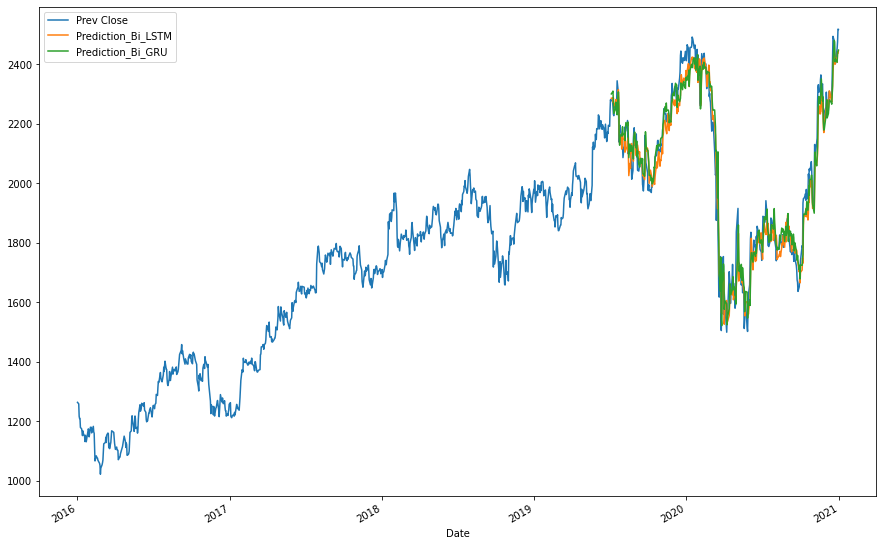

In [38]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

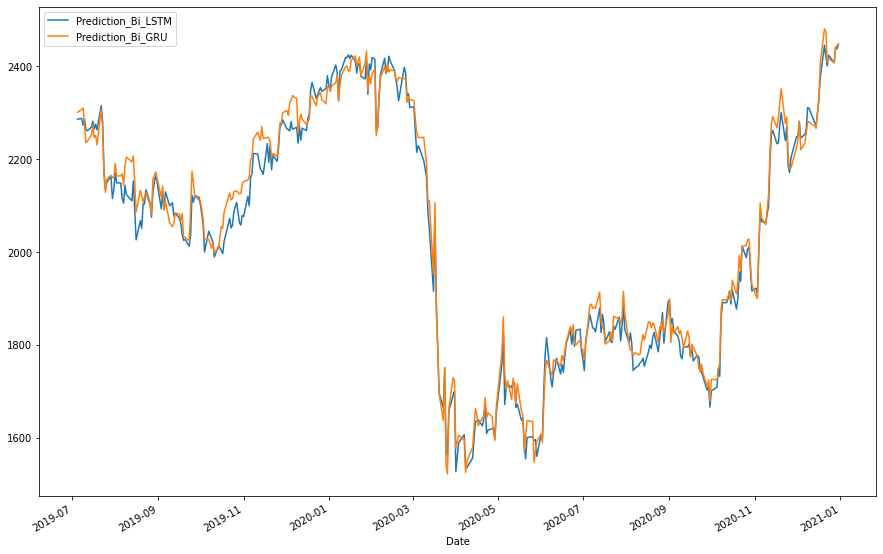

In [39]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [40]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [41]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

64.58267605146457


In [42]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

50.8746349019252


In [43]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.9428842936964358

In [44]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [45]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

62.63636939671357


In [46]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

47.09846689530781


In [47]:
r2_score(test['Prev Close'],pred_bi_gru)

0.9462749742769755